In [1]:
import rpy2
print(rpy2.__version__)

3.5.8


In [2]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

packnames = ('ggplot2', 'spam64')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

by .GlobalEnv when processing object ‘G’


In [3]:


import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
# cifti code based on Christopher J Markiewicz https://nbviewer.jupyter.org/github/neurohackademy/nh2020-curriculum/blob/master/we-nibabel-markiewicz/NiBabel.ipynb
# load cifti file containing the vertexwise values, in this case myelin map from the HCP
cifti = nb.load('HCP_S900_787_tfMRI_ALLTASKS_level3_zstat1_hp200_s2_MSMSulc.dscalar.nii') # download task data from HCP group average
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr = cifti.header
nifti_hdr = cifti.nifti_header

axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]

def surf_data_from_cifti(data, axis, surf_name): 
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")

left_brain=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')

#load gifti surface that is the same resolution/underlying mesh etc as the cifti
gifti_img_BaseBrain = nb.load('S900.L.sphere.32k_fs_LR.surf.gii')

#u_vals,u_index=np.unique(left_brain[:,0],return_inverse=True)

xyz_points=gifti_img_BaseBrain.darrays[0].data
]




pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
import numpy as np

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

ptsnew=appendSpherical_np(xyz_points)


In [5]:
# Load yeo networks on the surface


import numpy as np

YeoNetworks=np.zeros([left_brain.shape[0],7])
for i in range(7):
    cifti = nb.load('Yeo/7Networks' + str(i+1) + '.dscalar.nii')
    cifti_data = cifti.get_fdata(dtype=np.float32)
    cifti_hdr = cifti.header
    nifti_hdr = cifti.nifti_header
    axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
    left_brainYeo=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
    
    YeoNetworks[:,i]=left_brainYeo[:,0]





In [ ]:
# Load spin permutation tool and sanity check it is generating rotated brains as expected

from netneurotools import stats as statsNNT 
n_rotate=500


spins=statsNNT.gen_spinsamples(ptsnew[:,0:3],np.zeros(ptsnew.shape[0]),n_rotate=n_rotate, seed=23)

i=500 # number of rotations
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.grid(False)

ax.set_axis_off()
ax.scatter(ptsnew[:,0], ptsnew[:,1], ptsnew[:,2],c=YeoNetworks[spins[:,i],1:4].mean(axis=1),cmap='bwr')
ax.view_init(10,0)


In [10]:
# Perform lattice kriging with each Yeo network as the mask for prediction for each task. 

import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.robjects import r, pandas2ri
import pandas as pd
import scipy
from sklearn.metrics import DistanceMetric
import time
from scipy import stats

StartTime=time.time()
pandas2ri.activate()
LK = importr('LatticeKrig')
taskNames=np.loadtxt('TaskNames.txt',dtype=str,delimiter=',')
tasks=np.asarray([9,31,42,62,69,74,80])

LKPredAllTasksReal=np.zeros([ptsnew.shape[0],tasks.shape[0],YeoNetworks.shape[1]])
CorrLKPredReal=np.zeros([tasks.shape[0],YeoNetworks.shape[1]])
#for i in range(tasks.shape[0]):
for i in range(tasks.shape[0]):
    print('task' + str(tasks[i]))
    for j in range(YeoNetworks.shape[1]):
        print('Yeo' + str(j+1))
        
        task=tasks[i]
        pos_index=YeoNetworks[:,j]==1

        X_temp=np.degrees(ptsnew[pos_index,4])

        X1=FloatVector(X_temp[:])

        X_temp=np.degrees(ptsnew[pos_index,5])
        #X2=FloatVector(X_temp[rndChoice])
        X2=FloatVector(X_temp[:])
        Y_temp=left_brain[pos_index,task]
        #Y=FloatVector(Y_temp[rndChoice])
        Y=FloatVector(Y_temp[:])



        df = pd.DataFrame({'X1': X2, 'X2': X1})
        #df_predict = pd.DataFrame({'X1': X2_predict, 'X2': X1_predict})
        r_dataframe = pandas2ri.py2rpy(df)

        alpha=FloatVector(np.power([1,0.5,0.1],2))

        LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=1.01,alpha=alpha,LKGeometry="LKSphere",Radius=100) 

        #LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=6.1,alpha=[1,0.5,0.25],LKGeometry="LKSphere",distance_type='Chordal') 

        LKOutput=LK.LatticeKrig(r_dataframe,Y,LKinfo=LKinfo)

        X1_all=FloatVector(np.degrees(ptsnew[:,4]))
        X2_all=FloatVector(np.degrees(ptsnew[:,5]))
        Y_all=FloatVector(left_brain[:,task])


        #noMedialWall=left_brain[:,task]!=0
        #X1_all=FloatVector(np.degrees(ptsnew[noMedialWall,4]))
        #X2_all=FloatVector(np.degrees(ptsnew[noMedialWall,5]))
        #Y_all=FloatVector(left_brain[noMedialWall,task])

        df_all = pd.DataFrame({'X1': X2_all, 'X2': X1_all})

        r_dataframe_all = pandas2ri.py2rpy(df_all)
        LKPredAllTasksReal[:,i,j]=r.predict(LKOutput,r_dataframe_all).ravel()
        CorrLKPredReal[i,j]=stats.spearmanr(LKPredAllTasksReal[pos_index==0,i,j],left_brain[pos_index==0,task])[0]
        #count=count+1
        
        
print(time.time()-StartTime)




task9
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task31
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task42
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task62
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task69
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task74
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
task80
Yeo1
Yeo2
Yeo3
Yeo4
Yeo5
Yeo6
Yeo7
1107.5214829444885


In [49]:
# Perform lattice kriging with each Yeo network as the mask for prediction for each task, but rotating the mask on the sphere to generate null distribution.
# This is slow since has to perform 500 * 7 * 7 whole brain lattice kriging models

import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.robjects import r, pandas2ri
import pandas as pd
import scipy
from sklearn.neighbors import DistanceMetric
import time


pandas2ri.activate()
LK = importr('LatticeKrig')
taskNames=np.loadtxt('/Users/robleech/Dropbox/BrainSmash/TaskNames.txt',dtype=str,delimiter=',')
tasks=np.asarray([9,31,42,62,69,74,80])

n_rotate=200

def LKSpinYeo(k):

    LKPredAllTasks=np.zeros([ptsnew.shape[0],tasks.shape[0],YeoNetworks.shape[1]])
    PosIndexAll=np.zeros([ptsnew.shape[0],tasks.shape[0],YeoNetworks.shape[1]])

    #for i in range(tasks.shape[0]):
    for i in range(7):
        #print('task' + str(tasks[i]))
        for j in range(YeoNetworks.shape[1]):
            #print('Yeo' + str(j+1))

            task=tasks[i]
            pos_index=YeoNetworks[spins[:,k],j]==1

            X_temp=np.degrees(ptsnew[pos_index,4])

            X1=FloatVector(X_temp[:])

            X_temp=np.degrees(ptsnew[pos_index,5])
            #X2=FloatVector(X_temp[rndChoice])
            X2=FloatVector(X_temp[:])
            Y_temp=left_brain[pos_index,task]
            #Y=FloatVector(Y_temp[rndChoice])
            Y=FloatVector(Y_temp[:])



            df = pd.DataFrame({'X1': X2, 'X2': X1})
            #df_predict = pd.DataFrame({'X1': X2_predict, 'X2': X1_predict})
            r_dataframe = pandas2ri.py2rpy(df)

            alpha=FloatVector(np.power([1,0.5,0.1],2))

            LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=1.01,alpha=alpha,LKGeometry="LKSphere",Radius=100) 

            #LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=6.1,alpha=[1,0.5,0.25],LKGeometry="LKSphere",distance_type='Chordal') 

            LKOutput=LK.LatticeKrig(r_dataframe,Y,LKinfo=LKinfo)

            X1_all=FloatVector(np.degrees(ptsnew[:,4]))
            X2_all=FloatVector(np.degrees(ptsnew[:,5]))
            Y_all=FloatVector(left_brain[:,task])


            #noMedialWall=left_brain[:,task]!=0
            #X1_all=FloatVector(np.degrees(ptsnew[noMedialWall,4]))
            #X2_all=FloatVector(np.degrees(ptsnew[noMedialWall,5]))
            #Y_all=FloatVector(left_brain[noMedialWall,task])

            df_all = pd.DataFrame({'X1': X2_all, 'X2': X1_all})

            r_dataframe_all = pandas2ri.py2rpy(df_all)
            LKPredAllTasks[:,i,j]=r.predict(LKOutput,r_dataframe_all).ravel()
            PosIndexAll[:,i,j]=pos_index
    return LKPredAllTasks,PosIndexAll

        

import multiprocess as mp
import time

st=time.time()
with mp.Pool(8) as pool:
    #LKPredAllFrames=pool.map(LKrig, np.arange(nTR))
    SpinLKPredAllFrames =pool.map(LKSpinYeo, np.arange(n_rotate))
print(time.time()-st)




56800.01022839546


array([[0.54, 0.23, 0.04, 0.22, 0.3 , 0.26, 0.49],
       [0.27, 0.44, 0.33, 0.11, 0.03, 0.61, 0.37],
       [0.06, 0.36, 0.19, 0.21, 0.76, 0.2 , 0.08],
       [0.58, 0.8 , 0.82, 0.04, 0.24, 0.81, 0.66],
       [0.44, 0.79, 0.08, 0.04, 0.79, 0.84, 0.78],
       [0.11, 0.39, 0.18, 0.09, 0.13, 0.3 , 0.23],
       [0.53, 0.67, 0.07, 0.12, 0.18, 0.4 , 0.14]])

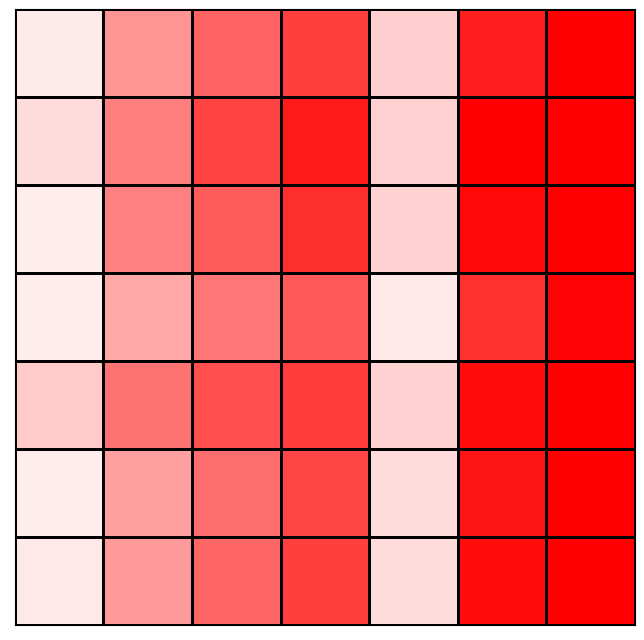

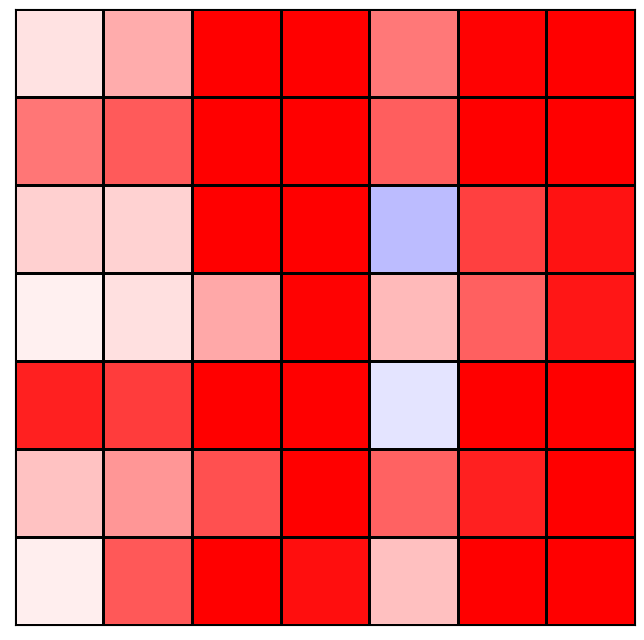

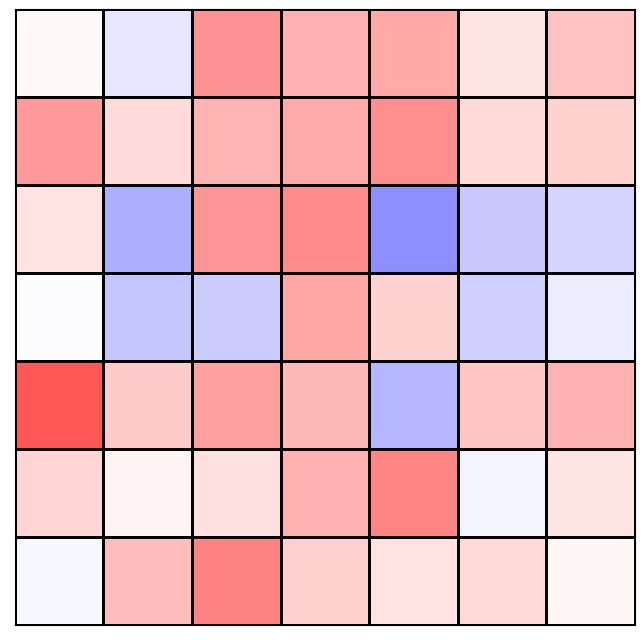

In [22]:
# Plot results


fig = plt.figure(figsize=(8, 8))

plt.pcolormesh((CorrSpinTaskYeo.mean(axis=0)), edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.savefig("SpinYeoByTask.png", bbox_inches='tight')


plt.show()

fig = plt.figure(figsize=(8, 8))

plt.pcolormesh(CorrLKPredReal, edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])
#plt.colorbar()
plt.savefig("YeoByTaskReal.png", bbox_inches='tight')



SpinPredVersusReal_PropGZero=np.zeros([7,7])
SpinPredVersusReal=np.zeros([7,7])
for i in range(7):
    for j in range(7):
        SpinPredVersusReal_PropGZero[i,j]=((CorrSpinTaskYeo[:,i,j]-CorrLKPredReal[i,j])>0).mean()
        SpinPredVersusReal[i,j]=(CorrLKPredReal[i,j]-CorrSpinTaskYeo[:,i,j]).mean()
SpinPredVersusReal_PropGZero
plt.show()


fig = plt.figure(figsize=(8, 8))

plt.pcolormesh(SpinPredVersusReal, edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])

plt.savefig("YeoSpinVersusReal.png", bbox_inches='tight')
plt.show()





In [16]:
# Save or load results from spin (which is very slow)
# Calculate the correlation between real and predicted values

#np.save('LKYeoSpin.txt', np.asarray(SpinLKPredAllFrames))

from scipy import stats

SpinLKPredAllFrames=np.load('LKYeoSpin.txt.npy')


SpinArray=np.asarray(SpinLKPredAllFrames)
tasks=np.asarray([9,31,42,62,69,74,80])

CorrSpinTaskYeo=np.zeros([100,7,7])
MaskMedialWallOverlap=CorrSpinTaskYeo.copy()
for i in range(100): # spin
    for j in range(7): # task
        for k in range(7): # yeo 
            tempPred=SpinArray[i,0,:,j,k]
            tempMask=SpinArray[i,1,:,j,k]
            tempReal=left_brain[:,tasks[j]]
            MaskMedialWallOverlap[i,j,k]=(tempReal[tempMask==1]==0).mean()
            CorrSpinTaskYeo[i,j,k]=stats.spearmanr(tempPred[tempMask==0],tempReal[tempMask==0])[0]




(100, 7, 7)

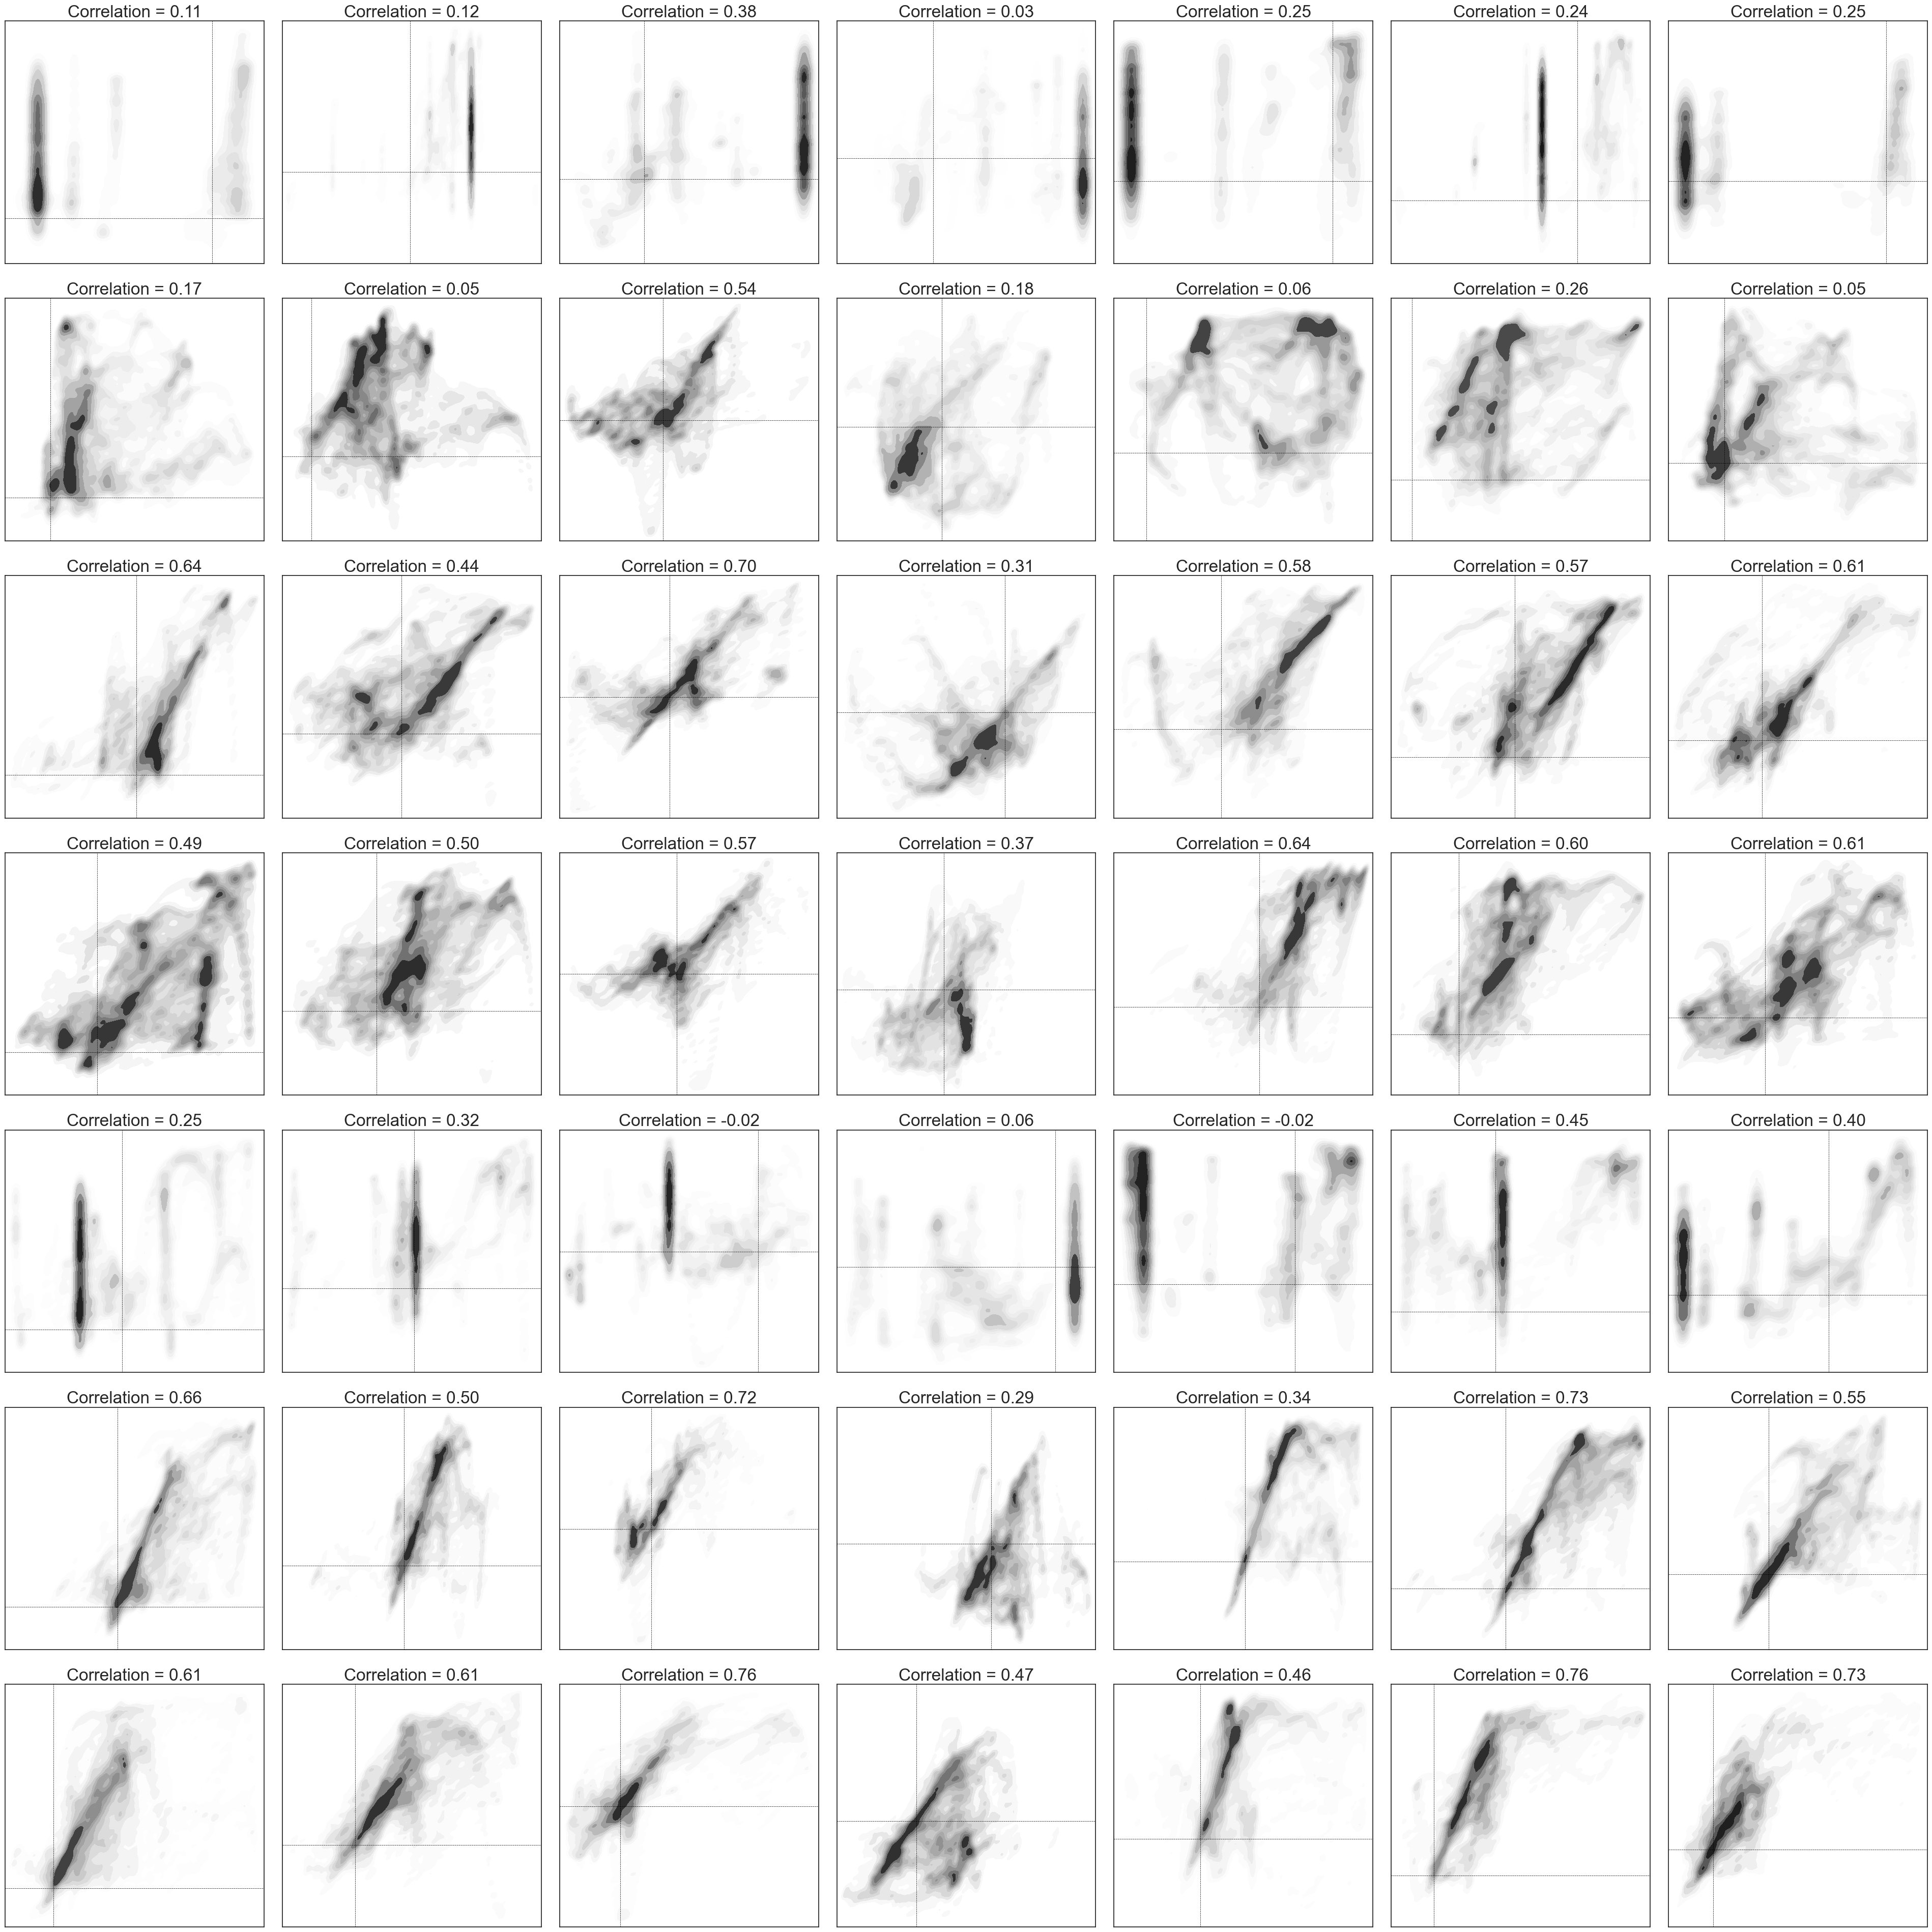

In [14]:
# Make scatter plots of real versus predicted activity in out-of-mask vertices

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
# Reset Matplotlib defaults
mpl.rcdefaults()

sns.set(font_scale=2)
sns.set_style('white') 

def customize_plot(ax,s_r):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.set_title(f"Correlation = {s_r}")
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)


corr_mat=np.zeros([7,7])

fig, axes = plt.subplots(YeoNetworks.shape[1], len(tasks), figsize=(5.5 * len(tasks), 5.5 * YeoNetworks.shape[1]))
LKPredAllTasks=LKPredAllTasksReal.copy()
for taskID, task in enumerate(tasks):

    for yeo_net in range(7): # Yeo
        pos_index=np.logical_and(YeoNetworks[:,yeo_net]==0,left_brain.mean(axis=1)>0)
        tempPred=LKPredAllTasks[pos_index,taskID,yeo_net].ravel()
        tempReal=left_brain[pos_index, task].ravel()
        #tempPred=# DELETE
        #tempReal=
        #clust_data = np.ravel(LKPredAllTasks[clust, taskID])
        #task_data = np.ravel(left_brain[clust, taskID])
        s_r=format(stats.spearmanr(tempPred,tempReal)[0], '.2f')
        corr_mat[yeo_net,taskID]=s_r
        # Convert to Pandas DataFrame
        df = pd.DataFrame({"LKPredAllTasks": tempPred, "left_brain": tempReal})

        ax = axes[yeo_net, taskID]
        #sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain", ax=ax,fill=True,cmap='bone_r')
        #ax.set_xlabel("LKPredAllTasks")
        #ax.set_ylabel("left_brain")
        #ax.set_title(f"Yeo {yeo_net+1} - Task {taskNames[tasks[taskID]]} Correlation {s_r}")
        sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain", fill=True, ax=ax, cmap="gray_r",bw_adjust=0.3,levels=10)

        customize_plot(ax,s_r)

plt.tight_layout()
#plt.show()

plt.savefig('ScatterMatrixTaskByYeo.png',dpi=600)


In [15]:
#SpinLKPredAllFrames=np.load('LKYeoSpin.txt.npy')


In [27]:

fig, axes = plt.subplots(1, num_tasks, figsize=(5.5 * num_tasks, 5))
count = 0
for taskID, task in enumerate(tasks):
    ax = axes[count]

    threshUpper = np.percentile(left_brain[:, task], 75, axis=0)
    pos_index = left_brain[:, task] > threshUpper
    neg_index = left_brain[:, task] < threshUpper

    
    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID])*-1
    task_data = np.ravel(left_brain[neg_index, task])*-1
    
    #clust_data=clust_data[np.abs(task_data>0)]
    #task_data=task_data[np.abs(task_data>0)]
    
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data, "left_brain": task_data})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain", fill=True, ax=ax, cmap="gray_r",bw_adjust=0.3,levels=10)

    customize_plot(ax,s_r)
    count += 1

plt.savefig('EachTaskScatterRealPred_lt_75pcPredPos.png')

fig2, axes = plt.subplots(1, num_tasks, figsize=(5.5 * num_tasks, 5))
count = 0
for taskID, task in enumerate(tasks):
    ax = axes[count]

    neg_index = left_brain[:, task] < 0

    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID]) * -1
    task_data = np.ravel(left_brain[neg_index, task]) * -1
    
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data, "left_brain": task_data})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain", fill=True, ax=ax, cmap="gray_r",bw_adjust=0.3,levels=10)
    
    customize_plot(ax,s_r)
    count += 1

plt.savefig('EachTaskScatterRealPred_ltPrePos_0.png')

plt.show()

(100, 2, 32492, 7, 7)

In [ ]:
import numpy as np

def erode_mask(vertices, triangles, mask, num_iterations):
    """
    Erodes the specified binary mask on a triangular mesh by contracting the mask by excluding non-selected vertices that have selected neighbors.
    
    Args:
        vertices (ndarray): A (n,3) array of vertex coordinates.
        triangles (ndarray): A (m,3) array of triangle indices into the vertex array.
        mask (ndarray): A (n,) binary mask indicating which vertices are selected.
        num_iterations (int): The number of erosion iterations to perform.
    
    Returns:
        ndarray: A (n,) binary mask indicating which vertices are selected after erosion.
    """
    for i in range(num_iterations):
        # create a copy of the current mask
        new_mask = np.copy(mask)
        
        # iterate over each vertex
        for v in range(len(vertices)):
            # check if the current vertex is selected
            if mask[v]:
                # check if any of the neighboring vertices are not selected
                neighbors = triangles[np.any(triangles == v, axis=1)].flatten()
                if not np.all(mask[neighbors]):
                    # if any of the neighbors are not selected, set the current vertex as not selected
                    new_mask[v] = False
        
        # update the mask with the newly computed values
        mask = new_mask
    
    return mask

In [ ]:
gifti_img_Midthickness = nb.load('/Users/robleech/Dropbox/HCP_S900_GroupAvg_v1/S900.L.midthickness_MSMAll.32k_fs_LR.surf.gii')
xyz_points_Mid=gifti_img_Midthickness.darrays[0].data
azim=0
Yeo7Erode=erode_mask(vertices,triangles, YeoNetworks[:,4].copy(),0)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
#p=ax.scatter(xyz_points[:,0],xyz_points[:,1],xyz_points[:,2],c=LKpred_all,s=3,cmap='bwr',vmin=-10,vmax=10)
p=ax.scatter(xyz_points_Mid[:,0],xyz_points_Mid[:,1],xyz_points_Mid[:,2],c=Yeo7Erode,s=3,cmap='Reds',vmin=0,vmax=1)
ax.view_init(elev=10., azim=180)

In [ ]:
# Erode Yeo7 and see if still performs best
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.robjects import r, pandas2ri
import pandas as pd
import scipy
from sklearn.neighbors import DistanceMetric

pandas2ri.activate()
LK = importr('LatticeKrig')
# cifti = nb.load('/Users/robleech/Dropbox/HCP_S900_GroupAvg_v1/HCP_S900_787_tfMRI_ALLTASKS_level3_zstat1_hp200_s2_MSMSulc.dscalar.nii')
# cifti_data = cifti.get_fdata(dtype=np.float32)
# cifti_hdr = cifti.header
# nifti_hdr = cifti.nifti_header

# axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
# left_brain=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
# left_brain=left_brain*-1
taskNames=np.loadtxt('/Users/robleech/Dropbox/BrainSmash/TaskNames.txt',dtype=str,delimiter=',')
tasks=np.asarray([9,31,42,62,69,74,80])


LKPredAllTasks=np.zeros([ptsnew.shape[0],tasks.shape[0],3]) # 3 levels of erosion

vertices=gifti_img_Midthickness.darrays[0].data
triangles=gifti_img_Midthickness.darrays[1].data

MaxNumErosion=3
for i in range(tasks.shape[0]):
    print('task' + str(tasks[i]))
    for j in range(MaxNumErosion):
        print('Erosion' + str(j+1))
        
        task=tasks[i]
        Yeo7Erode=erode_mask(vertices,triangles, YeoNetworks[:,6].copy(),j)
        pos_index=Yeo7Erode==1

        X_temp=np.degrees(ptsnew[pos_index,4])

        X1=FloatVector(X_temp[:])

        X_temp=np.degrees(ptsnew[pos_index,5])
        #X2=FloatVector(X_temp[rndChoice])
        X2=FloatVector(X_temp[:])
        Y_temp=left_brain[pos_index,task]
        #Y=FloatVector(Y_temp[rndChoice])
        Y=FloatVector(Y_temp[:])



        df = pd.DataFrame({'X1': X2, 'X2': X1})
        #df_predict = pd.DataFrame({'X1': X2_predict, 'X2': X1_predict})
        r_dataframe = pandas2ri.py2rpy(df)

        alpha=FloatVector(np.power([1,0.5,0.1],2))

        LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=1.01,alpha=alpha,LKGeometry="LKSphere",Radius=100) 

        #LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=6.1,alpha=[1,0.5,0.25],LKGeometry="LKSphere",distance_type='Chordal') 

        LKOutput=LK.LatticeKrig(r_dataframe,Y,LKinfo=LKinfo)

        X1_all=FloatVector(np.degrees(ptsnew[:,4]))
        X2_all=FloatVector(np.degrees(ptsnew[:,5]))
        Y_all=FloatVector(left_brain[:,task])


        #noMedialWall=left_brain[:,task]!=0
        #X1_all=FloatVector(np.degrees(ptsnew[noMedialWall,4]))
        #X2_all=FloatVector(np.degrees(ptsnew[noMedialWall,5]))
        #Y_all=FloatVector(left_brain[noMedialWall,task])

        df_all = pd.DataFrame({'X1': X2_all, 'X2': X1_all})

        r_dataframe_all = pandas2ri.py2rpy(df_all)
        LKPredAllTasks[:,i,j]=r.predict(LKOutput,r_dataframe_all).ravel()
        #count=count+1
        
        



